1. Descarga y exploración del corpus

Para empezar importo las librerias necesarias para subir el data set elegido y comenzar a trabajar

In [1]:
import numpy as np
import pandas as pd

In [2]:
import gzip

# Ruta al archivo en Colab
file_path = "/Users/gaby/Desktop/Datasets/reviews_Beauty_5.json.gz"  #El archivo lo cargué directamente al colab

# Leer el archivo comprimido
with gzip.open(file_path, "rt", encoding="utf-8") as f:
    df = pd.read_json(f, lines=True)


In [3]:
# Mostrar las primeras filas y si existen valores nulos 
#Asi veo las columas como:
#reviewText: Texto de la reseña.
#overall: Calificación en estrellas (1-5)
print(df.isnull().sum())
df.head(1)


reviewerID           0
asin                 0
reviewerName      1386
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014"


In [4]:
#Me quedo sólo con las columnas que me interesan e ignoro los na
df_beauty = df[['reviewText', 'overall']].dropna().copy()

df_beauty.head()



,reviewText,overall
0,Very oily and creamy. Not at all what I expect...,1
1,This palette was a decent price and I was look...,3
2,The texture of this concealer pallet is fantas...,4
3,I really can't tell what exactly this thing is...,2
4,"It was a little smaller than I expected, but t...",3


Análisis exploratorio:

Este ejercicio deberá contener:
- Cardinalidad del vocabulario (nuúmero de tokens)
- Distribución de reviews por número de estrellas
- Nº de reviews positivas y negativas
- N-grams más frecuentes
- Nubes de palabras
- Visualización en 2 dimensiones de algunos word embeddings calculados con
Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)
- Conclusiones de la exploración
- Cualquier otra métrica / exploración / cálculo que el alumno considere

In [5]:
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración

import re # preprocesado

In [6]:
#Forma 1: para tener una aproximación: sólo convierto a minúsculas y tokenizo por espacios, pero voy a tener el problema de sobretokenización al no sacar signos de puntuación
#splitted_reviews = df['reviewText'].dropna().str.lower().str.split()
splitted_reviews = df_beauty['reviewText'].str.lower().str.split()
words1 = [word for review in splitted_reviews for word in review]
vocabulary = Counter(words1)
print(f"Cardinalidad del vocabulario: {len(vocabulary)}")


Cardinalidad del vocabulario: 331106


In [7]:

#Forma 2: De la siguiente manera obtengo un valor más pequeño de tokens al sacar caracteres extraños y signos de puntuación
# Tokenizar las reviews (separar en palabras)
def tokenize(text):
    return re.findall(r'\b\w+\b', str(text).lower())

# Contar palabras únicas
vocab = Counter()
words2 = df_beauty["reviewText"].apply(lambda x: vocab.update(tokenize(x)))

# Número total de palabras únicas
print(f"Cardinalidad del vocabulario: {len(vocab)}")


Cardinalidad del vocabulario: 78055


Distribución de reviews según sentimiento (número de estrellas)

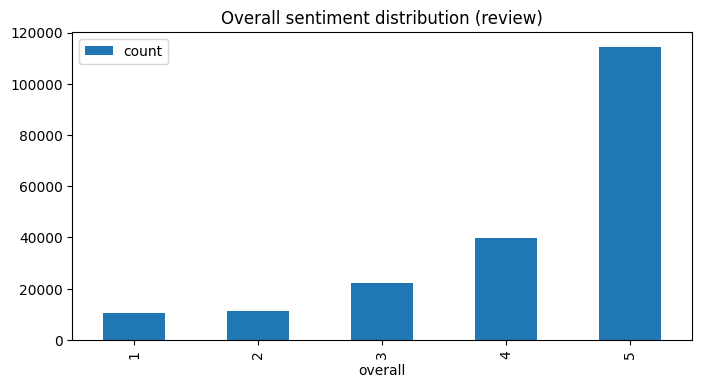

In [8]:
aux_df = pd.DataFrame(df_beauty['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

Nº de reviews positivas y negativas

In [9]:
#Defino 1 para reviews negativas (reviews puntuadas con 3 o menos estrellas) y 0 para reviews positivas(con 4 o más estrellas)
def label_sentiment(row):
    if int(row['overall']) <= 3:
        return 1
    else:
        return 0

In [10]:
#Creo la columna de 'sentiment_label'donde la review se clasifica como positiva(0) o negativa(1)
df_beauty['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)
df_beauty.head()


,reviewText,overall,sentiment_label
0,Very oily and creamy. Not at all what I expect...,1,1
1,This palette was a decent price and I was look...,3,1
2,The texture of this concealer pallet is fantas...,4,0
3,I really can't tell what exactly this thing is...,2,1
4,"It was a little smaller than I expected, but t...",3,1


Positive reviews: 154272
Negative reviews: 44230


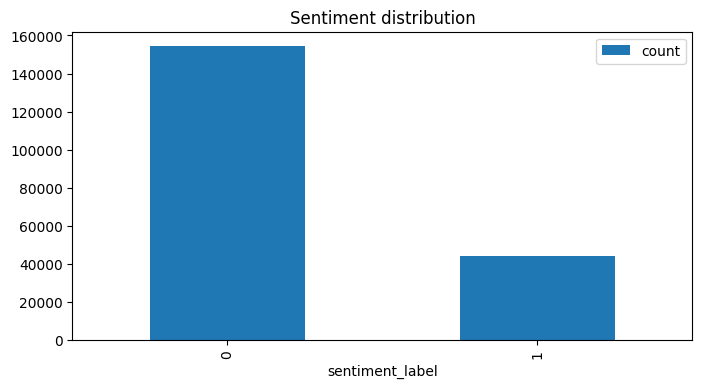

In [11]:
# Cuento reviews positivas (4 o 5 estrellas)
num_positives = df_beauty[df_beauty['overall'] >= 4].shape[0]

# Cuento reviews negativas (1 o 2 o 3 estrellas)
num_negatives = df_beauty[df_beauty['overall'] <= 3].shape[0]

# Muestro resultados analítica y gráficamente
print(f"Positive reviews: {num_positives}")
print(f"Negative reviews: {num_negatives}")

aux_df = pd.DataFrame(df_beauty['sentiment_label'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution', figsize=(8, 4))


N-grams más frecuentes (sólo miro bigramas y trigramas

In [12]:
#Forma1: "aproximado"
bigrams_ = ngrams(words1, 2)
trigrams_ = ngrams(words1, 3)



In [13]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [14]:
bigrams_freq_.most_common(10)

[(('i', 'have'), 71557),
 (('my', 'hair'), 57354),
 (('of', 'the'), 45891),
 (('it', 'is'), 45596),
 (('and', 'i'), 42771),
 (('in', 'the'), 41658),
 (('this', 'product'), 38769),
 (('this', 'is'), 38634),
 (('is', 'a'), 37597),
 (('on', 'my'), 33740)]

In [15]:
trigrams_freq_.most_common(10)

[(('this', 'is', 'a'), 11880),
 (('a', 'lot', 'of'), 9755),
 (('i', 'have', 'been'), 7142),
 (('i', 'love', 'this'), 6919),
 (('my', 'hair', 'is'), 6883),
 (('it', 'is', 'a'), 6591),
 (('i', 'use', 'it'), 6294),
 (('i', 'love', 'the'), 6061),
 (('this', 'product', 'is'), 5690),
 (('this', 'is', 'the'), 5584)]

In [16]:
#Forma2: "aproximado"--- me dan vacioo, por qué?

bigrams_2 = ngrams(words2, 2)
trigrams_2= ngrams(words2, 3)

In [17]:
bigrams_freq_2 = FreqDist(bigrams_)
trigrams_freq_2 = FreqDist(trigrams_)

In [18]:
trigrams_freq_2.most_common(10)

[]

Nubes de palabras

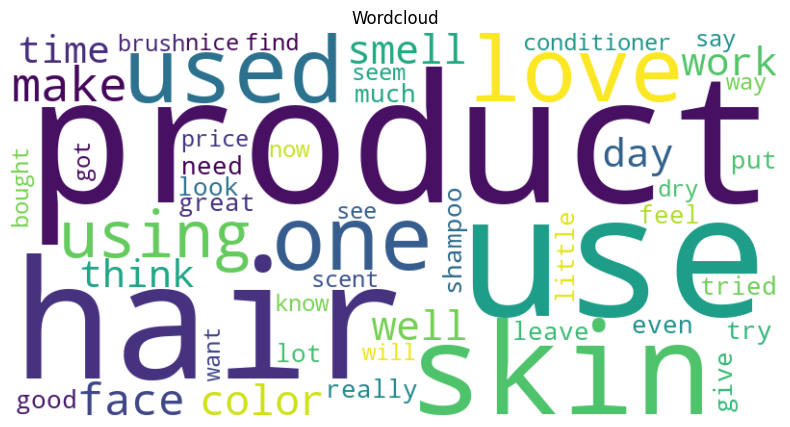

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Unir todos los textos en un solo string
text = " ".join(df_beauty['reviewText'].str.lower())

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=50).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Ocultar ejes
plt.title("Wordcloud")
plt.show()


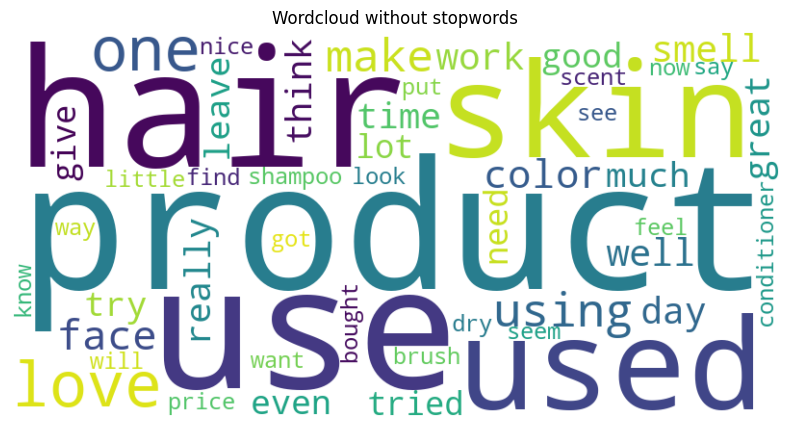

In [20]:
#Pruebo sacando las stopwords

from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
wordcloud2 = WordCloud(stopwords=stopwords, width=800, height=400, background_color="white", max_words=50).generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")  # Ocultar ejes
plt.title("Wordcloud without stopwords")
plt.show()


Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

In [21]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

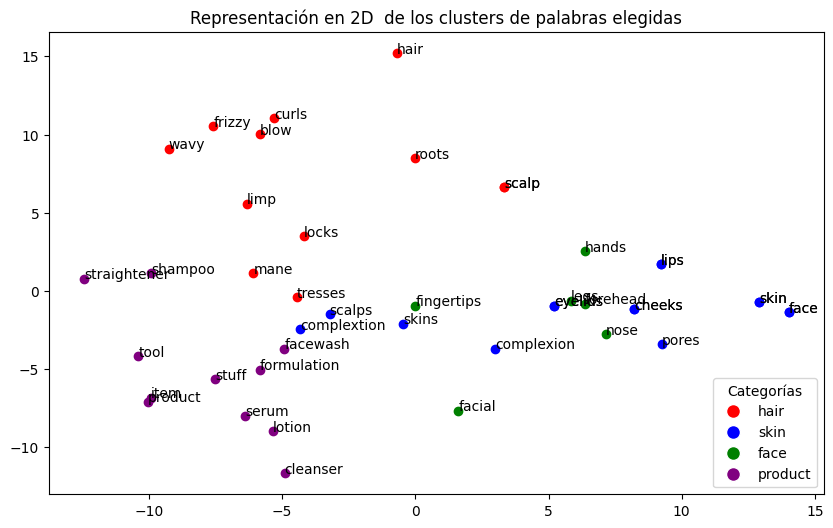

In [22]:
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# Se tokenizan las reviews para el modelo de Word2Vec y se entrena
sentences = df_beauty["reviewText"].dropna().apply(lambda x: tokenize(x)).tolist()

model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Se elijen las siguientes palabras en base al gráfico anterior (wordcloud) y según a mí criterio
# ya que son palabras que pueden ser categorias dentro de "Beauty"
keys = ["hair", "skin", "face", "product"]

# Se obtienen las 10 palabras más similares para cada una
similares = {word: [x[0] for x in model.wv.most_similar(word, topn=10)] for word in keys}

# Se obtienen los vectores de las keys y sus similares
words = sum(similares.values(), []) + keys
word_vectors = model.wv[words]

# Se reducen las dimensiones a 2D con PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Se definen los colores para cada grupo, de manera que se distingasn bien
colors = {
    "hair": "red",
    "skin": "blue",
    "face": "green",
    "product": "purple"
}

# Se crea el gráfico
plt.figure(figsize=(10, 6))

for i, word in enumerate(words):
    # Determinar el color según el grupo al que pertenece
    group = next((key for key in keys if word in [key] + similares[key]), "gray")
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1], color=colors.get(group, "gray"))
    plt.annotate(word, (word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[k], markersize=10, label=k) for k in keys]

plt.legend(handles=legend_patches, title="Categorías", loc="lower right")
plt.title("Representación en 2D  de los clusters de palabras elegidas")
plt.show()


En este gráfico podemos ver que los grupos se encuentra suficientemente separados como para identificarse los clusters según las palabras similares a "hair", "skin", "face", "product". Los que se superponen un poco son "face" y "skin", lo cual tiene sentido. Por otro lado palabras que se encuentran en categoría de "product" se encuentran más cercanas según en qué se usan, por ej: "shampoo" también podría pertenecer a la categoría de "hair", de ahí su cercanía en el gráfico. Ídem se pude ver con los productos para la piel ("skin" o "face") como ser "lotion" o "serum".

Basándonos en estos análisis, algunas conclusiones podrían ser:

Cardinalidad del vocabulario: Nos indica cuántas palabras únicas hay, útil para entender la riqueza del lenguaje en las reviews.
Distribución de estrellas: Permite ver si hay un sesgo en la calificación (por ejemplo, si la mayoría de reviews son de 5 estrellas).
Número de reviews positivas vs negativas: Nos ayuda a definir el balance de clases para un modelo de clasificación.
N-grams más frecuentes: Muestra frases comunes en las opiniones, que pueden dar pistas sobre qué características valoran los usuarios.
Nube de palabras: Nos da una idea visual de los términos más usados en las reseñas.
Word2Vec + PCA: Permite visualizar relaciones semánticas entre palabras en un espacio reducido.

In [23]:
#from sklearn.feature_extraction.text import TfidfVectorizer

# Ejemplo de reviews
#d = df_beauty["reviewText"]

# Creamos el vectorizador
#vectorizer = TfidfVectorizer()

# Ajustamos y transformamos los documentos
#X = vectorizer.fit_transform(df_beauty["reviewText"])

# Mostrar términos y valores TF-IDF
#import pandas as pd
#df_tfidf = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
#print(df_tfidf)


2. Etapa de preprocesado de texto

In [ ]:
def preprocess_data(data):
    # Se aplica lower case a la columna 'reviewText' 
    data['review'] = data['review'].str.lower()

    # Remove punctuation
    data['review'] = data['review'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

    data['review'] = data['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in spanish_stop_words]))

    return data